In [1]:
# this mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cs231n/assignments/assignment3/'
FOLDERNAME = "mango_class/"
assert FOLDERNAME is not None, "[!] Enter the foldername."

# now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

# this downloads the CIFAR-10 dataset to your Drive
# if it doesn't already exist.
%cd drive/My\ Drive/$FOLDERNAME/

Mounted at /content/drive
/content/drive/My Drive/mango_class


In [2]:
import torch
USE_GPU = True

# dtype = torch.float32 # we will be using float throughout this tutorial

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Constant to control how frequently we print train loss
print_every = 100

print('using device:', device)



using device: cuda


In [3]:
import os
import cv2
from PIL import Image#https://yungyuc.github.io/oldtech/python/python_imaging.html
import torchvision
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
from torch.utils.data import sampler
import numpy as np
from PIL import Image#https://yungyuc.github.io/oldtech/python/python_imaging.html




In [4]:
from py_files.dataloader2 import *


In [5]:
i = 4
# preprocess_img(i, '/C1-P1_Train_Dev_fixed/C1-P1_Train/batch' + str(i))

In [6]:
#in this cell, you can check if you had already finished preprocessing
#if ok: it will show 800
#else: it will show 0
# path = './C1-P1_Train_Dev_fixed/C1-P1_Train/batch' + str(i)
# path2 = path.replace("Train/","Train_after/")
# train_after_files = os.listdir(path2)
# print(len(train_after_files))

In [7]:
NUM_TRAIN = 1300
dataloaders = {"train":None, "dev":None}
dataset_sizes = {"train":None,"dev":None}
dataset = mango(
    pic_root='/C1-P1_Train_Dev_fixed_nobatch/C1-P1_Train/batch' + str(i),
    label_root = '/C1-P1_Train_Dev_fixed_nobatch/train.csv',
    preload=True,
    phase = "train",
)#把traning的dataset載下來
# batch_size =128

# trainset_loader = DataLoader(trainset, batch_size=batch_size
#                             , shuffle=True, num_workers=4)
trainset_loader = DataLoader(dataset, batch_size=128, 
                          sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

# dataset.phase = "dev"
devset_loader = DataLoader(dataset, batch_size=128, 
                        sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, 1400)))



In [8]:
# devset = mango(
#     pic_root='/C1-P1_Train_Dev_fixed/C1-P1_Dev',
#     label_root = '/C1-P1_Train_Dev_fixed/dev.csv',
#     preload=True,
#     phase = "dev",
# )#把dev的dataset載下來

# devset_loader = DataLoader(devset, batch_size=batch_size
#                             , shuffle=True, num_workers=4)
# # Use the torch dataloader to iterate through the dataset

dataloaders.update(train = trainset_loader)
dataloaders.update(dev = devset_loader)
dataset_sizes.update(train = len(trainset_loader))
dataset_sizes.update(dev = len(devset_loader))


In [9]:
path = './C1-P1_Train_Dev_fixed_nobatch/C1-P1_Train/batch' + str(i)
# path2 = path.replace("Train/","Train_after/")
train_files = os.listdir(path)
print(len(train_files))

1400


In [10]:

# Use the torch dataloader to iterate through the dataset



In [11]:
dataset_sizes["train"]
# devset_loader = DataLoader(devset, batch_size=800, shuffle=True, num_workers=1)
# Use the torch dataloader to iterate through the dataset

11

### Visualize the dataset

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


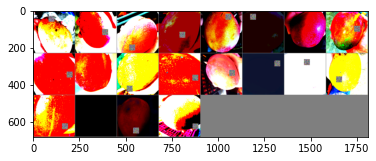

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


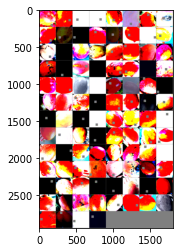

In [12]:
#這樣試看看
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

images = None
labels = None
# get some random training images
for images, labels in trainset_loader:
  images = images
  labels = labels

# print(type(train_images))
# show images
imshow(torchvision.utils.make_grid(images))
print("=======================================")
for images, labels in devset_loader:
  images = images
  labels = labels
imshow(torchvision.utils.make_grid(images))

In [13]:
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F
# from sklearn.svm import LinearSVC as svm
# from sklearn.model_selection import cross_validate
from sklearn.externals import joblib
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import copy

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [14]:
# model = models.densenet121(pretrained=True)

In [15]:
# model

In [45]:
model = models.densenet121(pretrained=True)
for param in model.parameters():
    param.requires_grad = False
# 替换最后的全连接层， 改为训练100类
# 新构造的模块的参数默认requires_grad为True
model.classifier = nn.Sequential(
    nn.Dropout(p=0.5, inplace=False),
    nn.Linear(in_features=1024, out_features=1024, bias=True),
    nn.ReLU(inplace=True),

    nn.Dropout(p=0.5, inplace=False),
    nn.Linear(in_features=1024, out_features=3, bias=True),

)
# model.load_state_dict(torch.load("model_params/batch" + str(7) + "_resnet18.pth"))

# if i == 1:
  
#   model.fc.load_state_dict(torch.load("model_params/batch" + str(7) + "_resnet18.pth"))
#   # optimizer_ft = optim.SGD(model.fc.parameters(), lr=1e-2, momentum=0.9)
#   # exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
# else:
#   model.fc.load_state_dict(torch.load("model_params/batch" + str(i-1) + "_resnet18.pth"))

#   # optimizer_ft = optim.SGD(model.fc.parameters(), lr=1e-2, momentum=0.9)
#   # print(optimizer_ft)
#   # optimizer_ft = optimizer_ft.load_state_dict(torch.load("optimizer_params/batch" + str(i-1) + "_resnet18.pth"))
#   # k=torch.load("optimizer_params/batch" + str(i-1) + "_resnet18.pth")
#   # print(k)
#   # exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
#   # exp_lr_scheduler = exp_lr_scheduler.load_state_dict(torch.load("exp_lr_scheduler_params/batch" + str(i-1) + "_resnet18.pth"))

#   print(f"already loaded fc layer of batch{i-1} model, show part of fc parameters of batch{i-1} model")

#   for pa in model.fc.parameters():
#     print(pa)


model = model.to(device)
criterion = nn.CrossEntropyLoss()
# 只优化最后的分类层
optimizer_ft = optim.SGD(model.classifier.parameters(), lr=1e-2, momentum=0.9)
# optimizer_ft = optim.Adam(model.classifier.parameters(), lr=0.01, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [46]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=5):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'dev']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                labels = torch.tensor(labels)
                inputs = inputs.to(device)
                labels = labels.to(device)
                # print(labels)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            if phase == 'train':
              train_acc = epoch_acc

            # deep copy the model
            if phase == 'dev' and epoch_acc > best_acc and train_acc - epoch_acc < 5:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best dev Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [47]:
model = train_model(model, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=40)

Epoch 0/39
----------


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


train Loss: 132.2259 Acc: 43.5455
dev Loss: 105.8417 Acc: 43.0000

Epoch 1/39
----------
train Loss: 127.7485 Acc: 48.9091
dev Loss: 99.8068 Acc: 51.0000

Epoch 2/39
----------
train Loss: 122.6389 Acc: 55.5455
dev Loss: 99.1190 Acc: 49.0000

Epoch 3/39
----------
train Loss: 119.4768 Acc: 57.2727
dev Loss: 100.1044 Acc: 45.0000

Epoch 4/39
----------
train Loss: 125.9459 Acc: 53.7273
dev Loss: 96.9933 Acc: 46.0000

Epoch 5/39
----------
train Loss: 118.9917 Acc: 60.4545
dev Loss: 101.3544 Acc: 52.0000

Epoch 6/39
----------
train Loss: 121.5689 Acc: 57.2727
dev Loss: 94.4386 Acc: 50.0000

Epoch 7/39
----------
train Loss: 121.0289 Acc: 56.9091
dev Loss: 93.5323 Acc: 56.0000

Epoch 8/39
----------
train Loss: 120.3184 Acc: 56.8182
dev Loss: 93.1737 Acc: 48.0000

Epoch 9/39
----------
train Loss: 118.2294 Acc: 57.1818
dev Loss: 96.4805 Acc: 53.0000

Epoch 10/39
----------
train Loss: 115.7689 Acc: 60.3636
dev Loss: 93.5585 Acc: 53.0000

Epoch 11/39
----------
train Loss: 111.5281 Acc: 6

In [22]:
ji3g4


NameError: ignored

In [48]:
for pa in model.classifier.parameters():
  pa = pa.requires_grad
  print(pa)

True
True
True
True


In [49]:
# #save the model
# state = {'svm_model': model}
# torch.save(state, "model_params/batch" + str(i) + "_svm_model.pth")
# # torch.save(model, "model_params/resnet18.pth")

In [50]:
torch.save(model.classifier.state_dict(), "model_params/nobatch" + str(i) + "_densenet121_try.pth")
# torch.save(optimizer_ft.state_dict(), "optimizer_params/nobatch" + str(i) + "_densenet121.pth")
# torch.save(exp_lr_scheduler.state_dict(), "exp_lr_scheduler_params/nobatch" + str(i) + "_densenet121.pth")

In [ ]:
# loal = torch.load(open("./model_params/nobatch"+str(i)+"_densenet121.pth", 'rb'))
# # dic = loaded_model['svm_model']
# # res = dic.score(inp, labels)
# loal["weight"]

In [ ]:
#以下是model(i)的測試